In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [ ]:
INIT_LR = 1e-3
EPOCHS = 20
BS = 32

In [ ]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images("/content/drive/MyDrive/Melanoma_Data/Raw_VGG16"))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the image, swap color channels, and resize it to be a fixed
	# 224x224 pixels while ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

[INFO] loading images...


In [ ]:
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
data = np.array(data) / 255.0
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [ ]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])


[INFO] compiling model...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
74/74 [==============================] - 83s 634ms/step - loss: 0.6633 - accuracy: 0.6280 - val_loss: 0.5998 - val_accuracy: 0.7462
Epoch 2/20
74/74 [==============================] - 29s 388ms/step - loss: 0.5812 - accuracy: 0.7253 - val_loss: 0.5284 - val_accuracy: 0.7663
Epoch 3/20
74/74 [==============================] - 30s 412ms/step - loss: 0.5409 - accuracy: 0.7482 - val_loss: 0.4953 - val_accuracy: 0.7730
Epoch 4/20
74/74 [==============================] - 30s 409ms/step - loss: 0.5060 - accuracy: 0.7613 - val_loss: 0.4781 - val_accuracy: 0.8013
Epoch 5/20
74/74 [==============================] - 29s 389ms/step - loss: 0.4962 - accuracy: 0.7782 - val_loss: 0.4557 - val_accuracy: 0.7863
Epoch 6/20
74/74 [==============================] - 30s 406ms/step - loss: 0.4785 - accuracy: 0.7850 - val_loss: 0.4478 - val_accuracy: 0.7947
Epoch 7/20
74/74 [==============================] - 29s 389ms/step - loss: 0.4717 - accuracy: 0.7888 - val_loss: 0.4317 - val_accuracy: 0.8147

In [ ]:
model.save("/content/drive/MyDrive/Melanoma_Data/VGG16.h5")

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

[INFO] evaluating network...


In [ ]:
print(predIdxs)

[1 1 0 1 1 1 0 0 1 0 0 1 1 1 0 1 0 1 0 1 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1
 1 0 1 0 0 1 1 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 1 1 0 1
 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1
 1 0 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 1 0 0 0 1 1 0 1 1 0 0 1 1 1 1 0
 0 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1
 0 0 0 1 1 0 1 0 1 1 1 0 1 0 0 1 0 1 0 0 1 0 0 1 0 1 1 1 1 0 0 0 0 1 1 1 1
 0 0 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 0 0 0 1 0 0 1 0 1 0 1 0 1 1 1 1 0 1 1 1
 1 1 1 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 0 1 0
 0 0 1 0 0 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 1 0 0 1 1
 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0 0 0 1 0 0
 1 0 1 1 0 1 0 1 1 1 0 0 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1
 1 1 1 1 0 1 1 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 1
 1 1 1 0 0 1 0 0 1 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 1 1 0 1 0 0 1 1 0 1 0 0 1
 1 1 0 0 0 0 1 0 0 0 1 1 

In [ ]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

              precision    recall  f1-score   support

      benign       0.88      0.73      0.80       299
   malignant       0.77      0.90      0.83       300

    accuracy                           0.81       599
   macro avg       0.82      0.81      0.81       599
weighted avg       0.82      0.81      0.81       599

acc: 0.8130
sensitivity: 0.7291
specificity: 0.8967


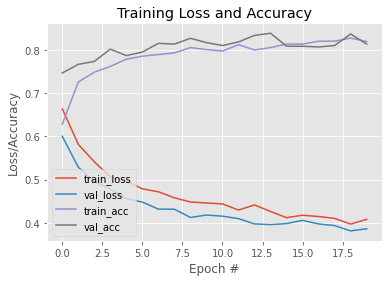

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

Confusion matrix, without normalization
[[218  81]
 [ 31 269]]


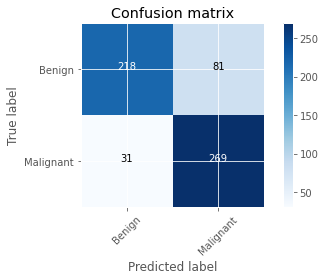

In [ ]:
#Evaluation of Model - Confusion Matrix Plot
import itertools 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(testY.argmax(axis=1), predIdxs)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign','Malignant'],
                      title='Confusion matrix')

In [ ]:
#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(testY.argmax(axis=1), predIdxs).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  223
False Positives:  76
False Negatives:  28
True Positives:  272
